##### Отправляем сообщения всегда, но узел может быть не активен (блокирован) тогда сообщение ставится в очередь на узел
##### после блокировки узел считается снова свободным если очередь < L
##### число узлов 300, поток ренерируется 150 шагов, плотность сети 3,08
MultiplierThresholdToBlock <strong>L 50</strong>, FractionThresholdToUnBlock 1, UseOnlyIsActiveNodes True, NumberOfGenerations 150 <br>


In [1]:
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime
import pandas as pd
import os
from labellines import labelLine, labelLines
  
log_dir_path = os.path.abspath('..\\..\\')+"\\Result"
numberOfGenerations = 150;
percolation = 0.37;
nodeCount=300;

files = [
    {"filename": "Netsim-Node-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на узле на обработку", "ylabel":"Число сообщений" },
    {"filename": "Netsim-Node-Metrics-load-{log_tag}", "title": "Загрузка узлов", "ylabel":"Доля от производительности узла" },
    #{"filename": "Netsim-Connection-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на связи"},
    {"filename": "Netsim-Connection-Metrics-load-{log_tag}", "title": "Средняя загрузка связей", "ylabel":"Доля от производительности связи" },
    {"filename": "Netsim-Message-Metrics-failed-{log_tag}", "title": "Число потерянных сообщений", "ylabel":"Число сообщений" },
]

filesBlocked = [
    {"filename": "Netsim-Node-Metrics-blocked-{log_tag}", "title": "Доля блокированных узлов" },
]

filesMessage = [
    {"filename": "Netsim-Message-Metrics-{log_tag}", "title": "Число доставленных сообщений с течением времени" },

]
summBlocked = pd.DataFrame();
MessageResived = pd.DataFrame();
MessageFall = pd.DataFrame();
MessageTimeSpent = pd.DataFrame();
          
def load_csv_file(path):
    file = open(path)
    data = file.readlines()
    splitted_data = [x.split(',') for x in data]
    return splitted_data, len(splitted_data[0])


def aggeregate_line(array):
    aggregated = [sum([float(y) for y in x])/len(x) for x in array]
    return aggregated, len(aggregated)


def showStat():
    for file in files:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel(file['ylabel'])
        
        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line(data)
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label'])    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
        #labelLines(plt.gca().get_lines(), zorder=2.5)
        #lines = plt.gca().get_lines();
        #print(len(lines))
        #xvals = get_xvals(lines)
        #for idx in range(len(lines)-1):
        #    labelLine(lines[idx+1], get_x(xvals, idx, len(lines)-1), label=str(idx+1), fontsize=14, align=False)
                                   
    plt.show()
                                           
def get_xvals(lines):
    ax = lines[0].axes
    shrink_factor = 0.05
    xvals = ax.get_xlim()
    xvals_rng = xvals[1] - xvals[0]
    shrinkage = xvals_rng * shrink_factor
    xvals = (xvals[0] + shrinkage, xvals[1] - shrinkage)
    return xvals;
                                           
def get_x(xvals, i, count):
    h = (xvals[1] - xvals[0])/(count+1);
    return h*(i+1)+xvals[0];
                                           
                                           
def aggeregate_line_perc_node(array):
    aggregated = [sum([1 for y in x if float(y) > 0])/len(x) for x in array]
    return aggregated, len(aggregated)

def showStatBlocked():
    for file in filesBlocked:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.axhline(y=percolation, color='r', linestyle='-')
        plt.xlabel("Шаги")
        plt.ylabel("Доля блокированных узлов")

        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line_perc_node(data)
            summ = np.sum(aggregated)
            summBlocked.at[quantity, log_tag['label']] = summ/count;
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()


def str2bool(v):
    return v.lower() in ("yes", "true", "t", "1")

def load_csv_file_message(path):
    file = open(path)
    data = file.readlines()
    t = datetime(2021,6,1,1)
   
    splitted_data = [(str2bool(x.split(',')[-2]), (datetime.strptime(x.split(',')[-1], '%d.%m.%Y %H:%M:%S\n')-t).total_seconds(), float(x.split(',')[2]))  for x in data]
    df = pd.DataFrame(data=splitted_data,  columns=['Resived', 'Time' ,'TimeSpent']);
    total_count = len(df.index);
    timeSpent_avr = df['TimeSpent'].mean();
    df = df.loc[df['Resived'] == True]
    agg= df.groupby(['Time']).count()
    return agg['Resived'].to_numpy(), agg.index.get_level_values(0).to_numpy(), total_count, timeSpent_avr

def showStatMessage():
    for file in filesMessage:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel("Число сообщений")
       
        for log_tag in log_tags:
            data, line_len, all_count, timeSpent_avr = load_csv_file_message(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            summ = np.sum(data);
            fall = (all_count-summ)*100/all_count;
            print('Доставлено '+str(summ)+' Потеряно '+ "{:3.4f}".format(fall)+'% -'+log_tag['label']);
            
            MessageResived.at[quantity, log_tag['label']] = summ*100/all_count;
            MessageFall.at[quantity, log_tag['label']] = fall;
            MessageTimeSpent.at[quantity, log_tag['label']] = timeSpent_avr;
            ax.plot(line_len, data, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    plt.show()


<strong>Поток Quantity 100 </strong>

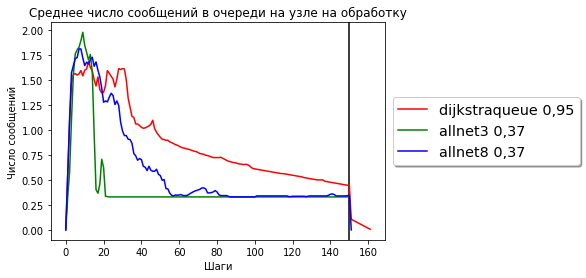

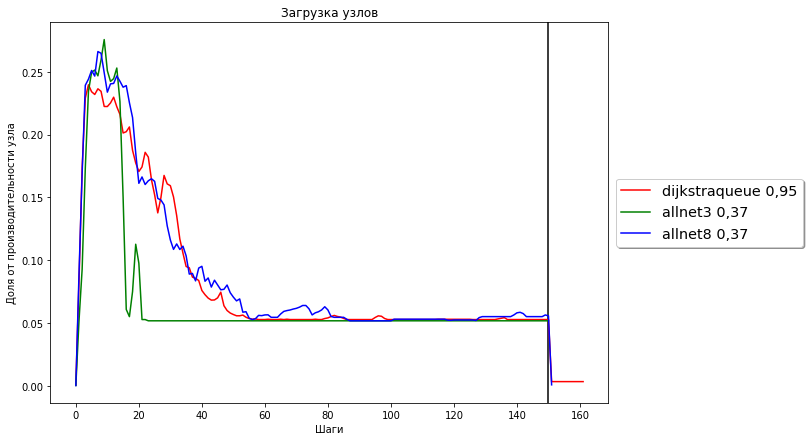

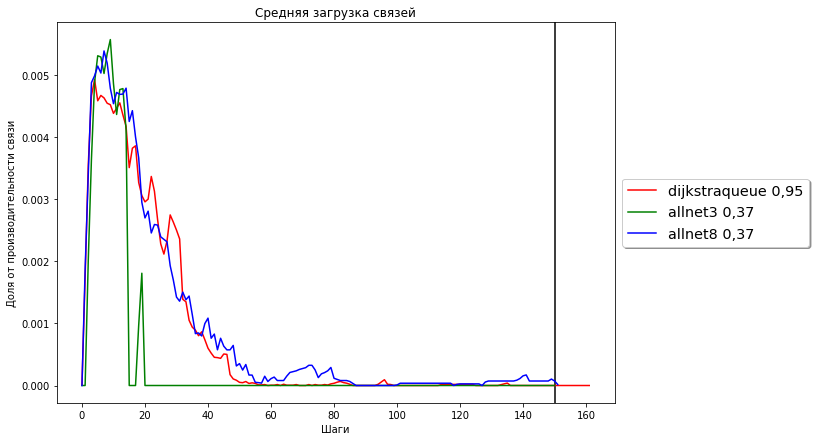

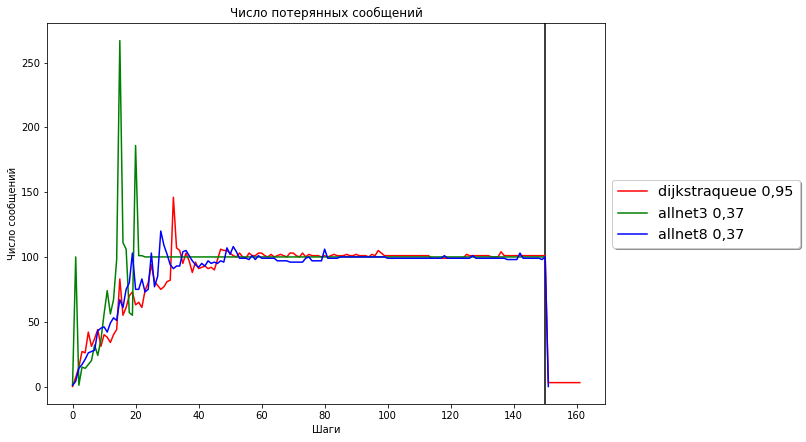

Доставлено 1262 Потеряно 91.5872% -dijkstraqueue 0,95
Доставлено 606 Потеряно 95.9603% -allnet3 0,37
Доставлено 1322 Потеряно 91.1873% -allnet8 0,37


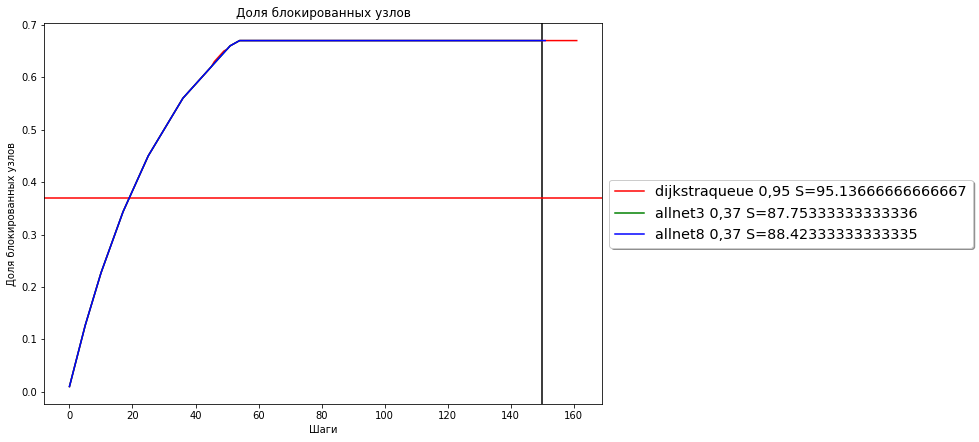

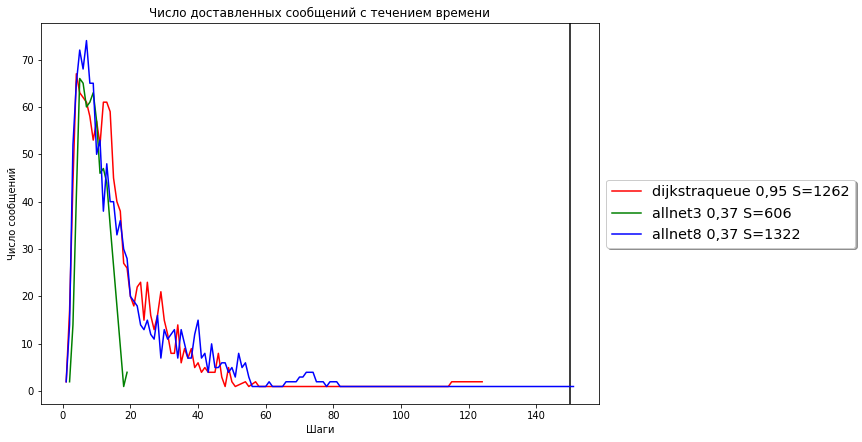

In [2]:
quantity = 100;
log_tags = [
{"tag":  "9b6d10cf-ce51-44d0-8743-ebf395d984e0", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "04b7fa99-4a0a-4c77-8d8b-097a8c7b4845", "label": "allnet3 0,37", "color": "green"},
{"tag":  "9c8fcc28-6583-4778-a943-887d56c26dde", "label": "allnet8 0,37", "color": "blue"},

]
                             
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 500 </strong>

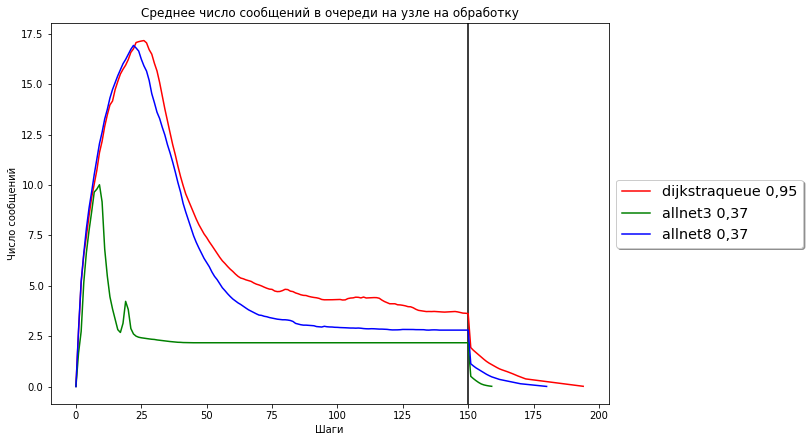

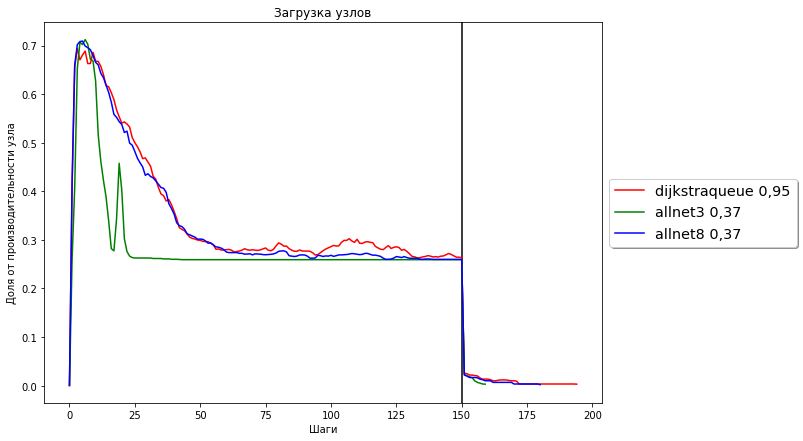

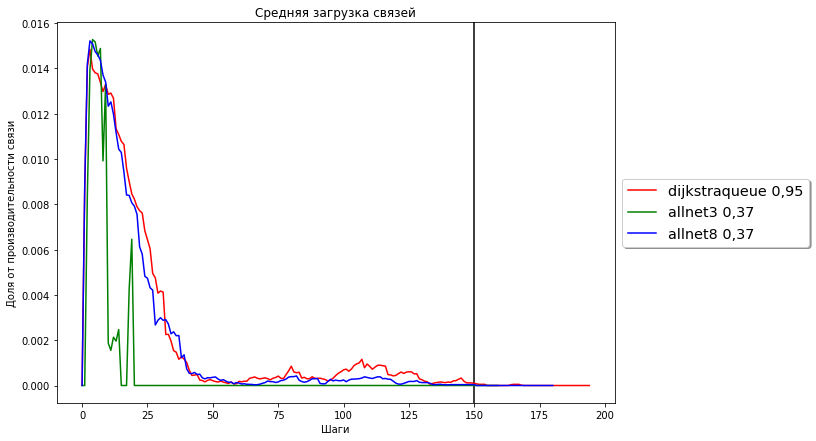

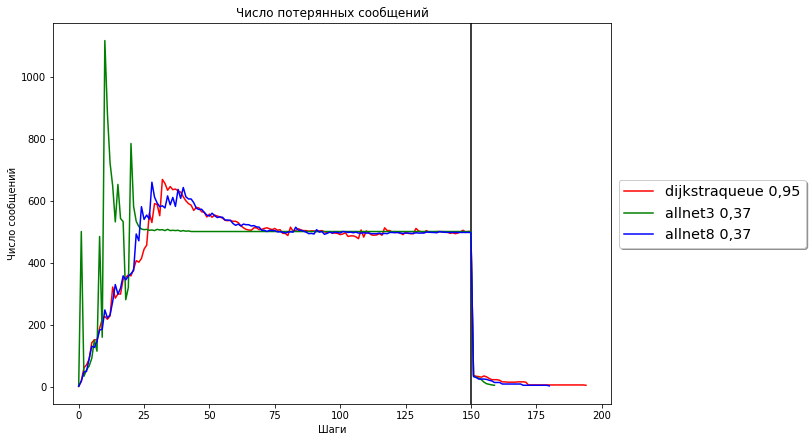

Доставлено 2919 Потеряно 96.1081% -dijkstraqueue 0,95
Доставлено 982 Потеряно 98.6907% -allnet3 0,37
Доставлено 2767 Потеряно 96.3107% -allnet8 0,37


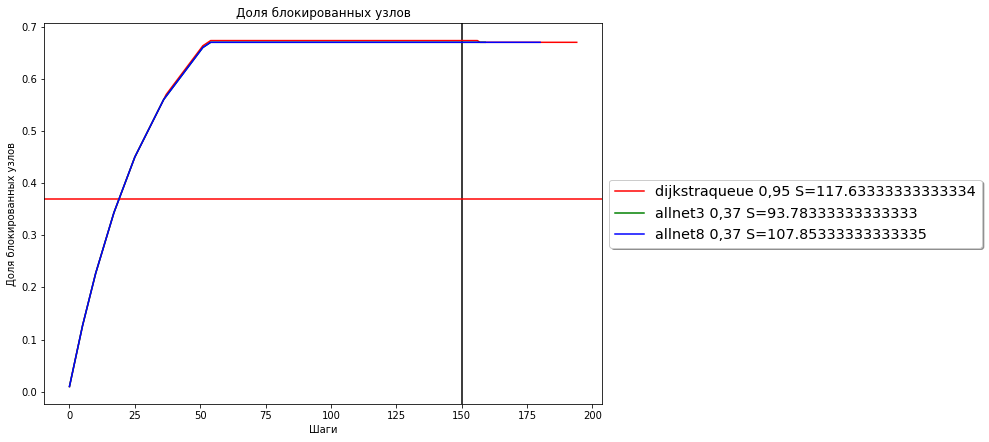

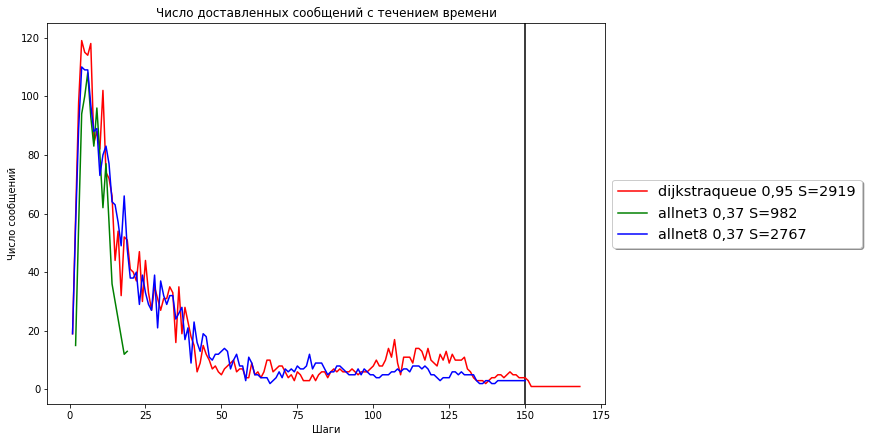

In [3]:
quantity = 500;
log_tags = [
{"tag":  "c8bac8a6-0397-40e3-ae90-40eee2e013e9", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "64207306-9272-4f7c-af71-a5ed61bb4ab9", "label": "allnet3 0,37", "color": "green"},
{"tag":  "68c6e761-860d-4d35-adce-c16c3cfcb8a7", "label": "allnet8 0,37", "color": "blue"},

]
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 1000 </strong>

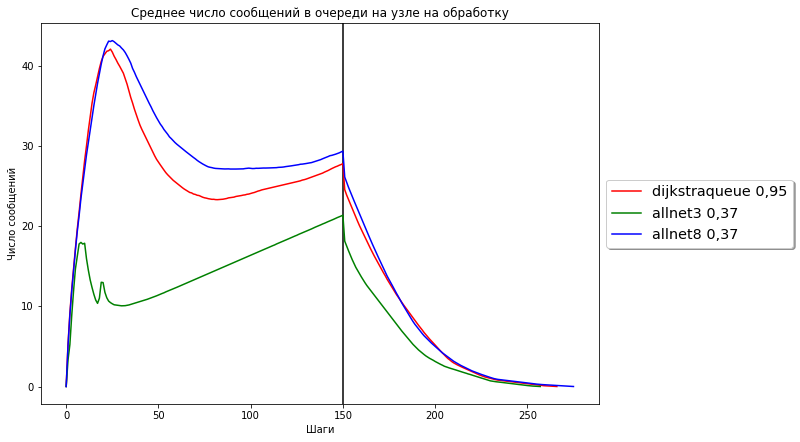

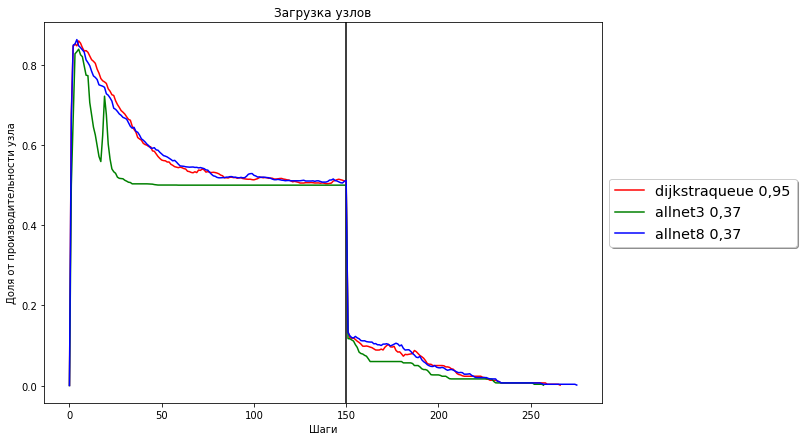

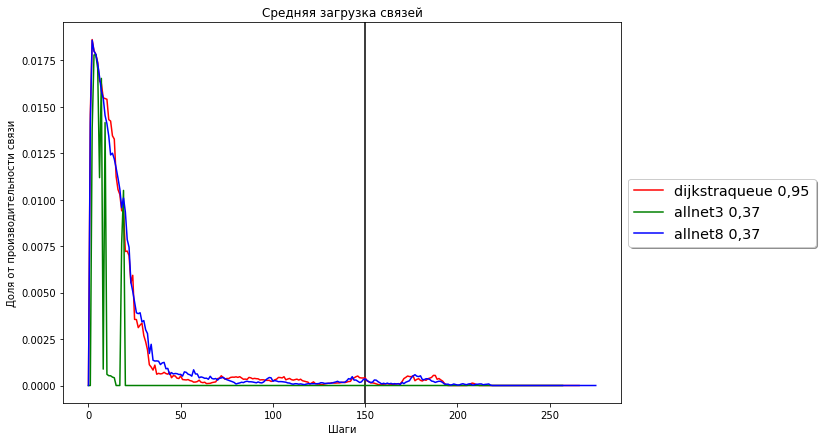

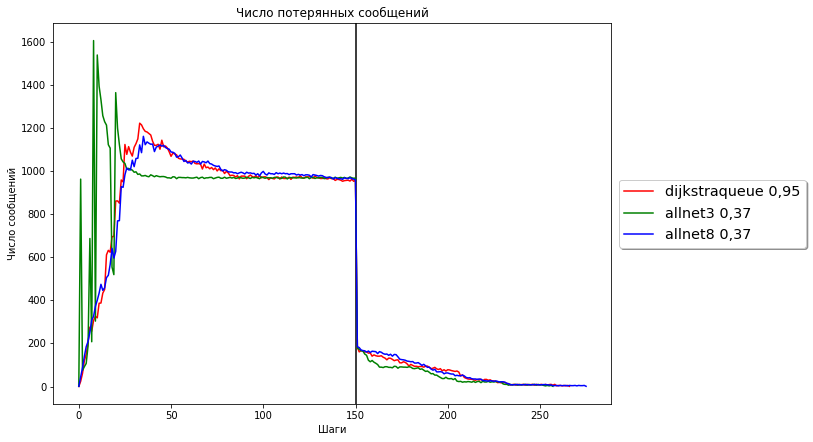

Доставлено 2910 Потеряно 98.0600% -dijkstraqueue 0,95
Доставлено 598 Потеряно 99.6013% -allnet3 0,37
Доставлено 2993 Потеряно 98.0047% -allnet8 0,37


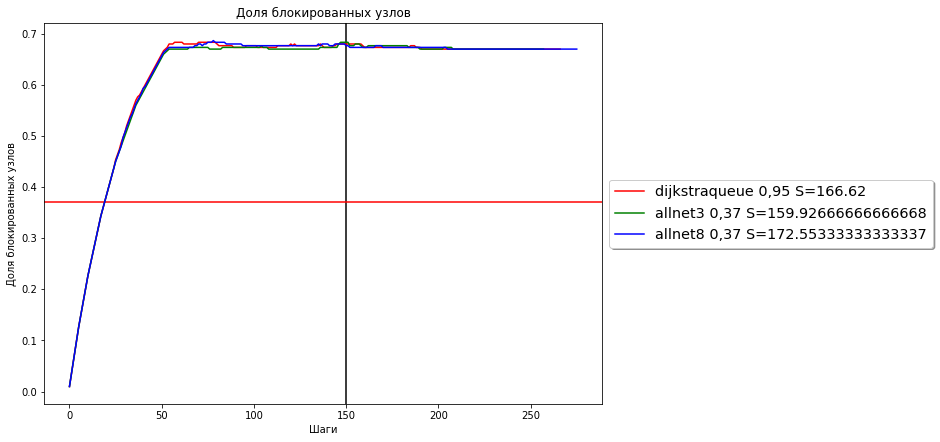

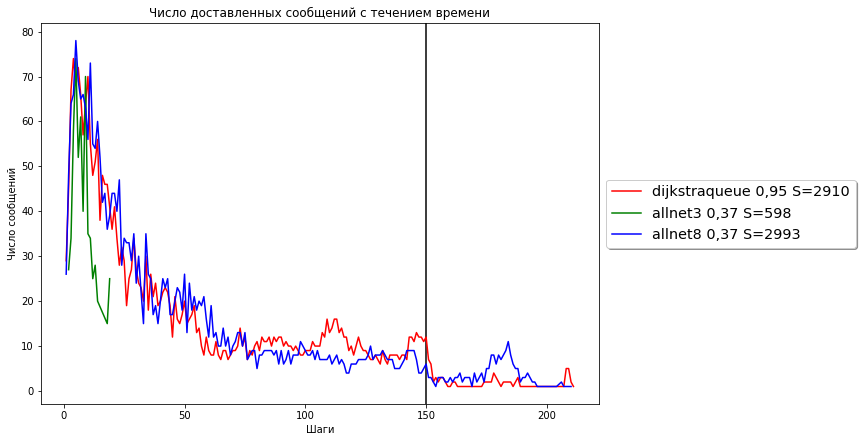

In [4]:
quantity = 1000;
log_tags = [
{"tag":  "bd5e2eae-ba83-4a5e-901e-f6988e04a7ba", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "8e0b30ef-1a21-434d-97d4-7f172f719c5e", "label": "allnet3 0,37", "color": "green"},
{"tag":  "47973a2c-08b4-4592-b952-0c1fdebc464f", "label": "allnet8 0,37", "color": "blue"},

]
showStat()
showStatBlocked();  
showStatMessage();

<strong>Quantity 1500 </strong>

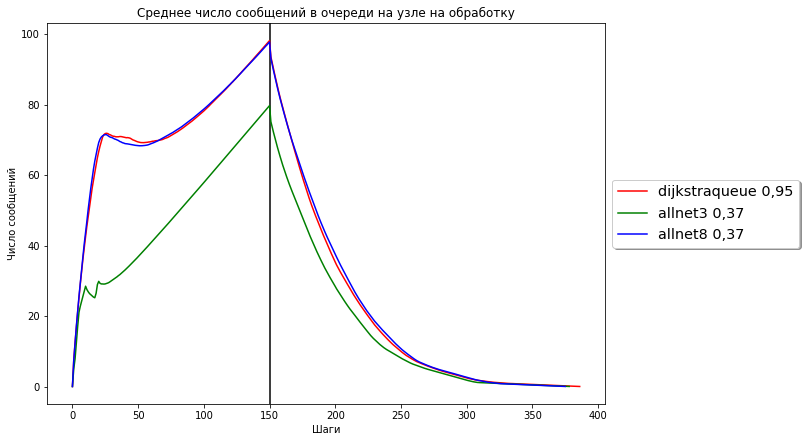

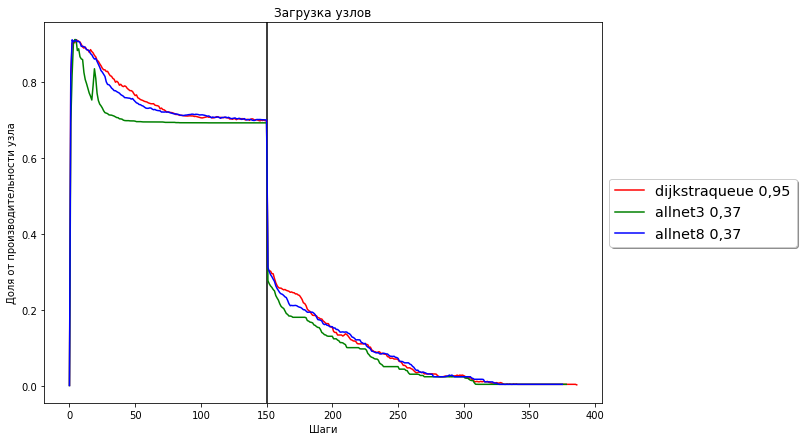

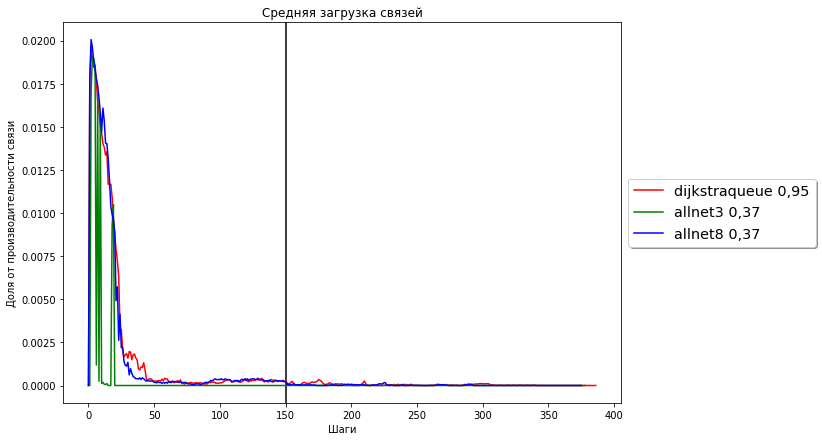

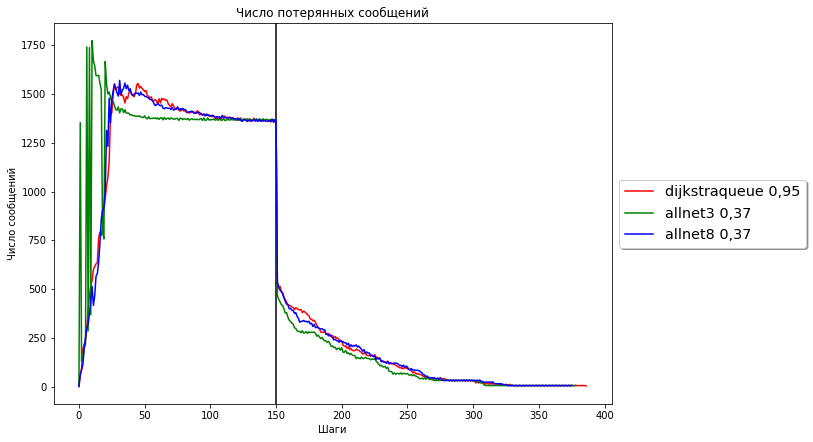

Доставлено 2542 Потеряно 98.8702% -dijkstraqueue 0,95
Доставлено 359 Потеряно 99.8404% -allnet3 0,37
Доставлено 2915 Потеряно 98.7045% -allnet8 0,37


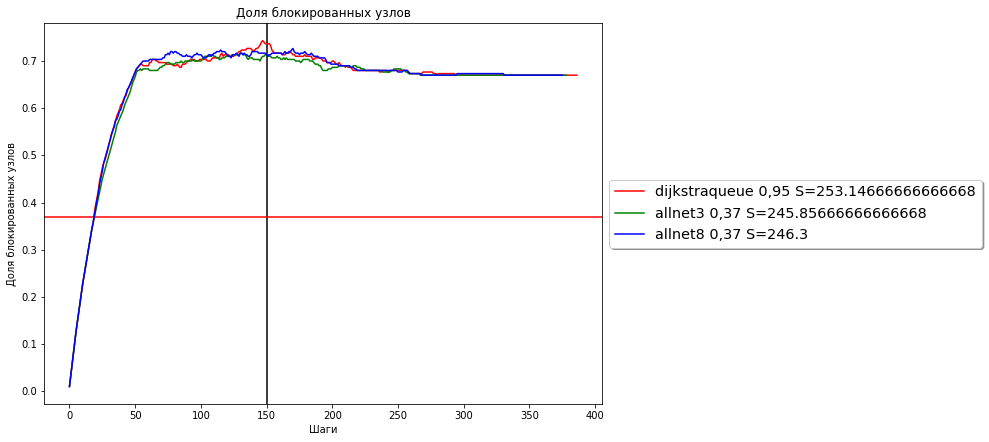

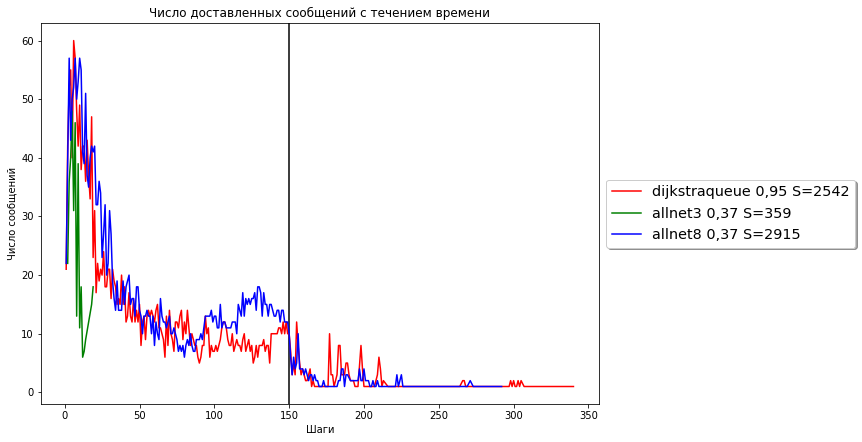

In [5]:
quantity = 1500;
log_tags = [
{"tag":  "9c0244e6-5ab6-4030-a7a6-12fcb06560e5", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "5af880fa-012d-4d1e-b052-e3c0e22a09cd", "label": "allnet3 0,37", "color": "green"},
{"tag":  "0f5fdc26-bb27-4dc8-8b9d-8d4f587a47ce", "label": "allnet8 0,37", "color": "blue"},

]
showStat()
showStatBlocked();  
showStatMessage();

Доставлено 2367 Потеряно 94.7401% -dijkstraqueue 0,95
Доставлено 888 Потеряно 98.0267% -allnet3 0,37
Доставлено 2622 Потеряно 94.1735% -allnet8 0,37


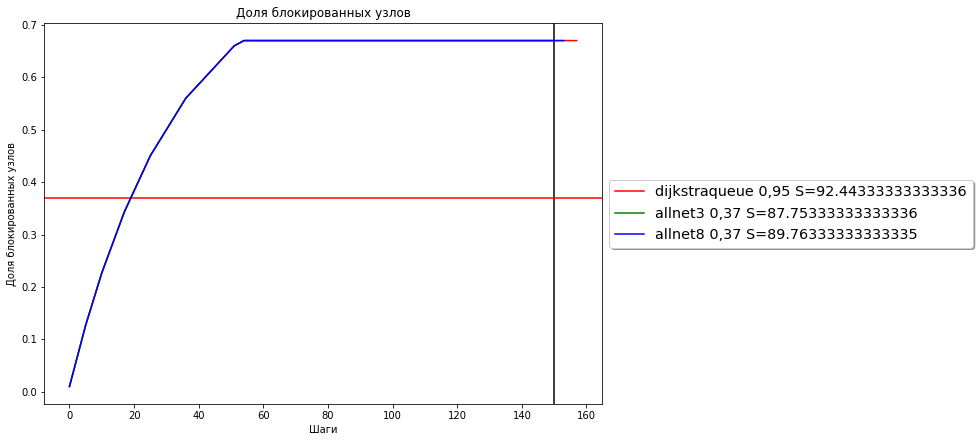

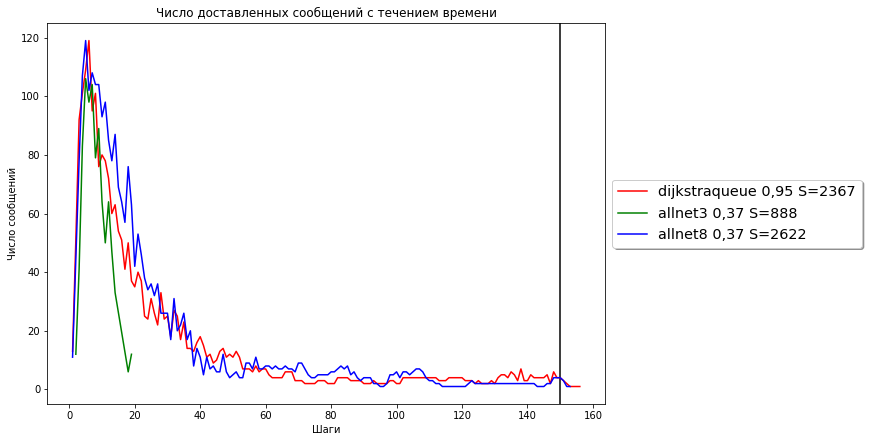

Доставлено 2935 Потеряно 97.2048% -dijkstraqueue 0,95
Доставлено 780 Потеряно 99.2571% -allnet3 0,37
Доставлено 3579 Потеряно 96.5915% -allnet8 0,37


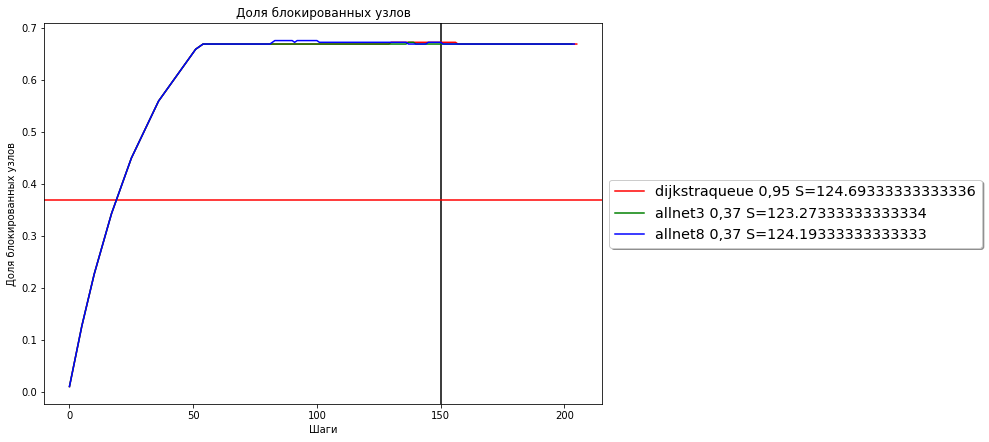

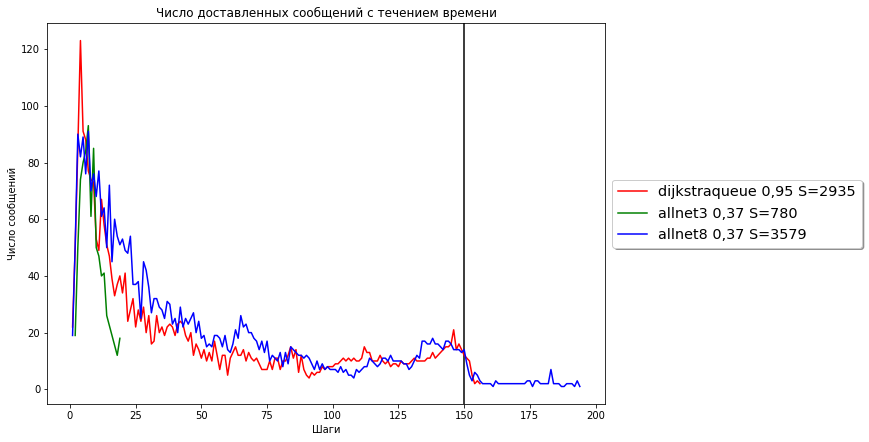

Доставлено 3142 Потеряно 97.6726% -dijkstraqueue 0,95
Доставлено 636 Потеряно 99.5289% -allnet3 0,37
Доставлено 3182 Потеряно 97.6430% -allnet8 0,37


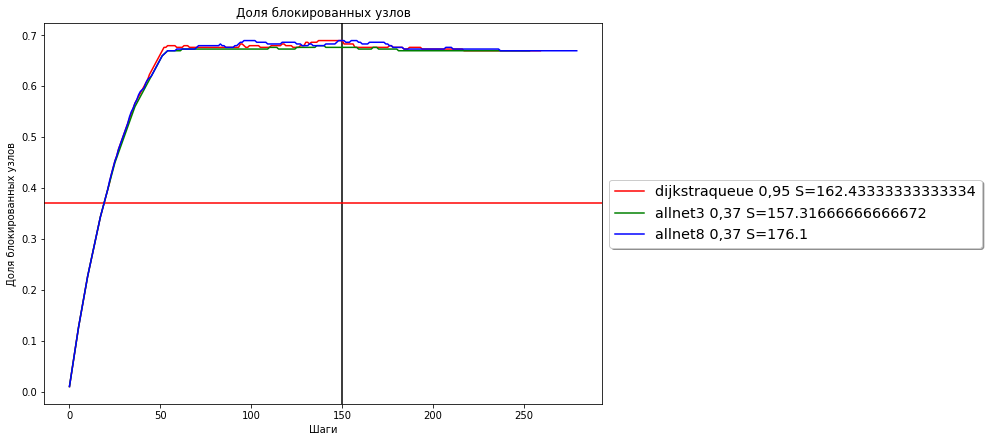

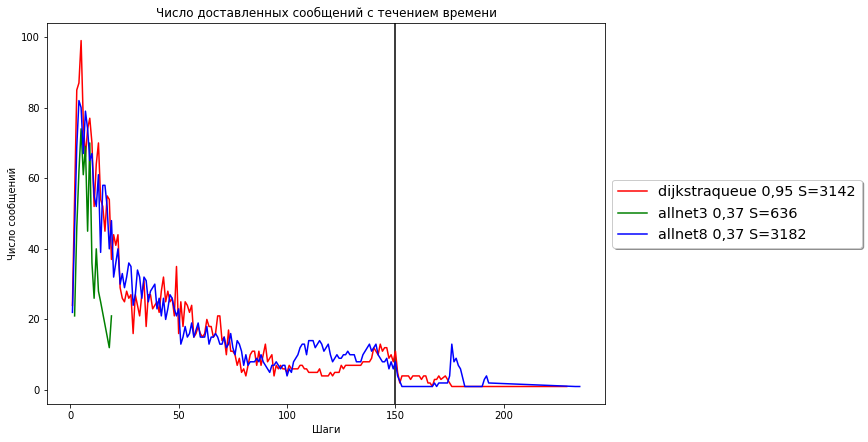

Доставлено 2538 Потеряно 98.6985% -dijkstraqueue 0,95
Доставлено 462 Потеряно 99.7631% -allnet3 0,37
Доставлено 2948 Потеряно 98.4882% -allnet8 0,37


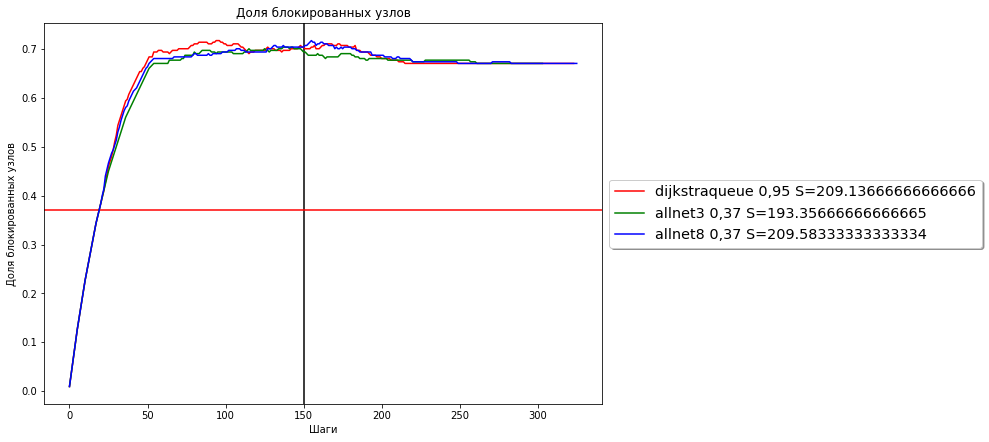

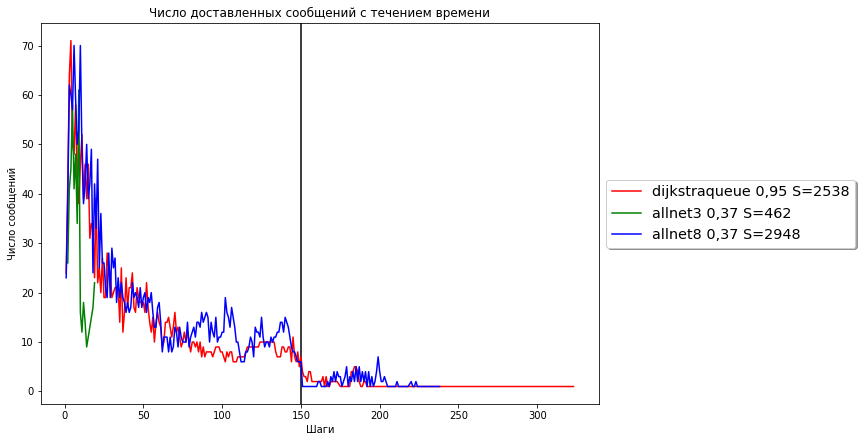

In [6]:
quantity = 300;
log_tags = [
{"tag":  "f6b8138b-cb3b-4348-909d-d11b8c521de0", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "f971a82b-ed4b-47e0-b69b-0040ef183898", "label": "allnet3 0,37", "color": "green"},
{"tag":  "e1a77b08-4087-4879-8470-7696808932e3", "label": "allnet8 0,37", "color": "blue"},

]
showStatBlocked();  
showStatMessage();
quantity = 700;
log_tags = [
{"tag":  "6d2b9f33-ac12-46a7-9435-190f0f35f005", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "5377ba6f-5c85-42fd-822d-8c2cfa35dcd6", "label": "allnet3 0,37", "color": "green"},
{"tag":  "8067c4eb-72cf-41e9-b270-a50cffadb1be", "label": "allnet8 0,37", "color": "blue"},

]
showStatBlocked();  
showStatMessage();
quantity = 900;
log_tags = [
{"tag":  "faae6f44-cee6-44d9-95ee-92ec40c8ff1c", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "955ec9c7-23d8-405e-b45c-aca8be570ee4", "label": "allnet3 0,37", "color": "green"},
{"tag":  "805bffea-ad6c-4a6f-93da-d806b7716357", "label": "allnet8 0,37", "color": "blue"},

]
showStatBlocked();  
showStatMessage();
quantity = 1300;
log_tags = [
{"tag":  "e5d1682b-1939-48ee-9234-c995092c2fd2", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "01812426-b745-4e9a-ac70-b6768dfd10db", "label": "allnet3 0,37", "color": "green"},
{"tag":  "2db0b9f0-88c5-4928-b081-82195ab48f34", "label": "allnet8 0,37", "color": "blue"},

]
showStatBlocked();  
showStatMessage();

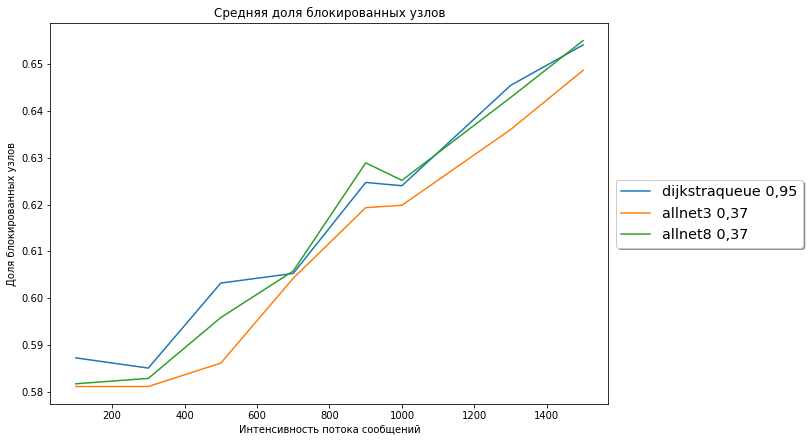

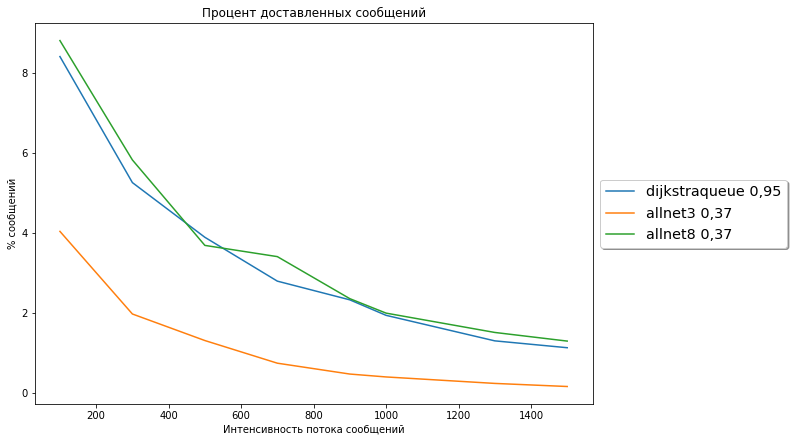

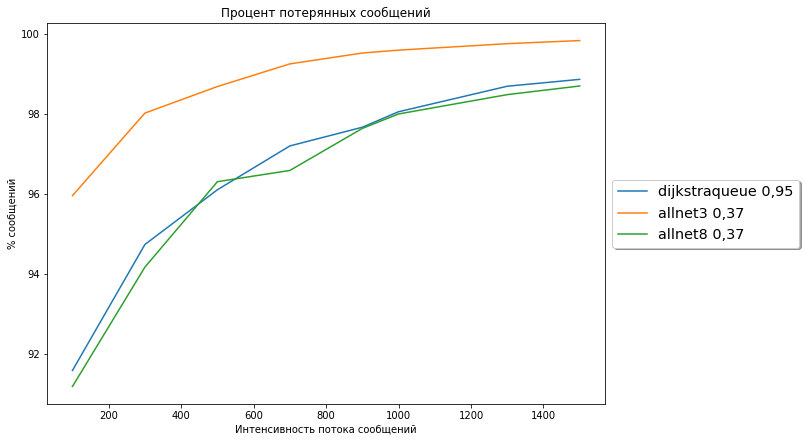

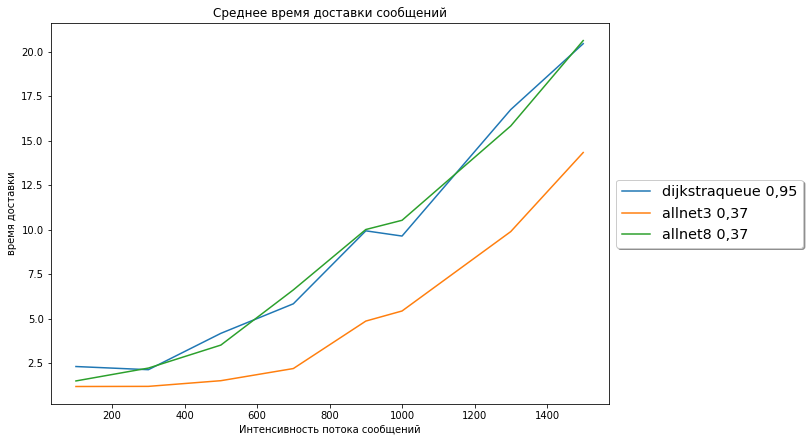

In [7]:
summBlocked.sort_index(inplace=True)
axs = summBlocked.plot()
axs.set_title("Средняя доля блокированных узлов")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("Доля блокированных узлов")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageResived.sort_index(inplace=True)
axs = MessageResived.plot()
axs.set_title("Процент доставленных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageFall.sort_index(inplace=True)
axs = MessageFall.plot()
axs.set_title("Процент потерянных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageTimeSpent.sort_index(inplace=True)
axs = MessageTimeSpent.plot()
axs.set_title("Среднее время доставки сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("время доставки")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()


In [8]:
print(summBlocked.mean().to_string())
print("")
print(MessageFall.mean().to_string())
print("")
print(MessageTimeSpent.mean().to_string())

dijkstraqueue 0,95    0.616163
allnet3 0,37          0.609586
allnet8 0,37          0.614797

dijkstraqueue 0,95    96.617688
allnet3 0,37          98.833571
allnet8 0,37          96.387902

dijkstraqueue 0,95    8.908408
allnet3 0,37          5.087424
allnet8 0,37          8.860772
